In [1]:
import tensorflow as tf
from tensorflow import keras
from attention_dynamic_model import AttentionDynamicModel
from utils import create_data_on_disk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

2022-10-25 07:37:59.273049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Solution Inspector Notebook

This notebook helps inspect the solutions produced by AM-D models.

In [3]:
# AM-D Initial Model Parameters. Make sure they match the original hyperparameters
embedding_dim   = 128
n_encode_layers = 2
n_heads         = 8
tanh_clipping   = 10

# Create model, duh!
model_amd = AttentionDynamicModel(
    embedding_dim  =embedding_dim,
    n_encode_layers=n_encode_layers,
    n_heads        =n_heads,
    tanh_clipping  =tanh_clipping
)

# Import weights.
model_amd.load_weights('checkpoints/AM-D_example')

In [4]:
# Generate data.
data = create_data_on_disk(20, 100, False, None, True, 42)

In [62]:
# This is only to see that data generated uses tf's dataset API
data

<TensorSliceDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), TensorSpec(shape=(20, 2), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

## Solve Problems

This section of the notebook shows the importation and use of an AM-D model to solve generated problems.

In [40]:
# Obtain data for testing
test_data = next(data.batch(5).as_numpy_iterator())

### Generate solutions using AM-D ###
model_amd.set_decode_type('greedy')
res = model_amd(test_data, return_pi=True)

In [84]:
res

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([7.7612996, 7.84948  , 5.980508 , 5.6322303, 6.047707 ],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-2.7911527, -3.3225899, -2.6462145, -4.4916945, -1.9156253],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 30), dtype=float32, numpy=
 array([[20.,  9., 14.,  6.,  0.,  0.,  0.,  0.,  0., 17.,  7., 10.,  4.,
         19., 15.,  0.,  0.,  1., 13.,  3.,  2., 18., 16.,  5.,  0., 11.,
          8., 12.,  0.,  0.],
        [ 1., 10., 19., 11.,  9., 15.,  2.,  0.,  0.,  3.,  6., 13., 18.,
         14.,  8.,  0.,  0., 17., 16.,  5.,  0.,  0.,  0.,  0.,  0., 20.,
          7.,  4., 12.,  0.],
        [20., 15., 10., 16.,  7.,  9.,  4.,  3.,  0., 17., 12., 11., 18.,
         19., 13.,  5.,  0.,  2.,  6., 14.,  8.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [19., 11., 15.,  8.,  3., 14.,  9., 17.,  0., 10., 18.,  2.,  6.,
         13.,  0.,  0.,  0.,  7., 20.,  5.,  4., 12.,  1.,  0.,  0.

In [85]:
# Which sample to vizualize?
testing_sample = 3

# Collect data for vizualization the original problem
start_node = pd.DataFrame([test_data[0][testing_sample]])
space_nodes = pd.DataFrame(test_data[1][testing_sample])
nodes = pd.concat([start_node, space_nodes]).reset_index(drop=True).rename(columns={0: 'x', 1: 'y'})

In [86]:
# Collect cost (reward is -cost)
cost = res[0][testing_sample]

# Note: res[1] is the log-likelihood used for REINFORCE, so we can ignore here.

# Collect chosen trajectories
selections = pd.DataFrame(res[2][testing_sample], columns=['node #']).astype(int)

In [87]:
selections

,node #
0,19
1,11
2,15
3,8
4,3
5,14
6,9
7,17
8,0
9,10


In [88]:
# Collect nodes' (x, y) locations
path = nodes.iloc[selections['node #']]
#path = path.rename(columns={0: 'x', 1: 'y'})

In [89]:
path

,x,y
19,0.702106,0.077430
11,0.857648,0.098881
15,0.994854,0.223098
8,0.838887,0.280447
3,0.806631,0.239094
14,0.703548,0.295566
9,0.814406,0.393283
17,0.537190,0.170327
0,0.186020,0.114308
10,0.682887,0.424266


In [90]:
# All of this code re-creates the above table but adds the labels for plotting initial problem

gen_data = test_data
sample   = testing_sample
__type   = 1 # 1: space nodes, 0: depot node
# Collect all other nodes
graph    = pd.DataFrame(gen_data[__type][sample], columns=['x', 'y'])
# Collect depot node
depot = {
    'x': gen_data[0][sample][0], 
    'y': gen_data[0][sample][1], 
    'type': 'depot'
}

graph = graph.assign(type='node').append(depot, ignore_index=True)

graph

/tmp/ipykernel_12622/53454811.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.assign(type='node').append(depot, ignore_index=True)


,x,y,type
0,0.269504,0.086049,node
1,0.710304,0.534089,node
2,0.806631,0.239094,node
3,0.039118,0.648361,node
4,0.146153,0.599119,node
5,0.539597,0.588479,node
6,0.174031,0.532909,node
7,0.838887,0.280447,node
8,0.814406,0.393283,node
9,0.682887,0.424266,node


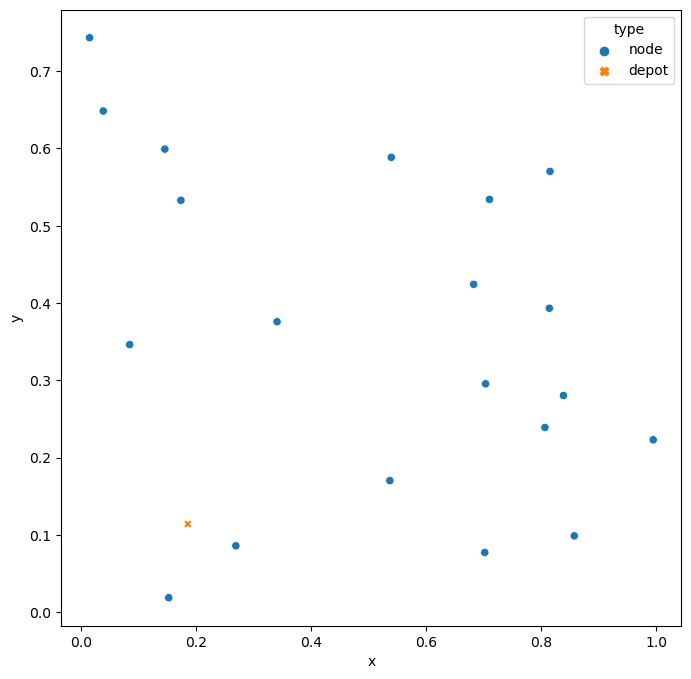

In [91]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=graph, x='x', y='y', hue='type', style='type')
plt.show()

/tmp/ipykernel_12622/670386366.py:14: RuntimeWarning: invalid value encountered in divide
  plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')


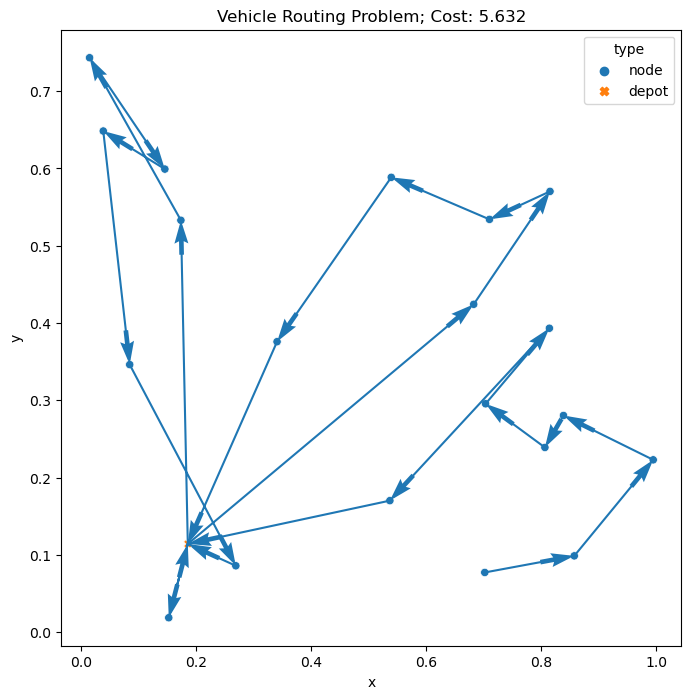

In [92]:
plt.figure(figsize=(8, 8))

x = path['x'].values
y = path['y'].values
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/1
pos_y = y[:-1] + v/1
norm = np.sqrt(u**2+v**2)

#plt.scatter(path[0], path[1], zorder=1)
sns.scatterplot(data=graph, x='x', y='y', hue='type', style='type')
plt.plot(path['x'], path['y'], zorder=2)
plt.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=0, pivot="tip", color='tab:blue')
plt.title(f'Vehicle Routing Problem; Cost: {cost:.3f}')
plt.show()